Взять CIFAR100 и обучить resnet18 с нуля на нем

Определить легкие и тяжелые объекты по лоссам итоговой модели

Взять другую модель и обучить её для CIFAR100  двумя способами:

1)объекты в рандомном порядке n эпох

2)чем больше номер эпохи чем больше вероятность выбрать сложный объект 

(да,распределение на индексах:вероятность выбрать объект сначала тем меньше,тем он сложнее,по ходу обучения распределение выходит на равномерное)

In [4]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

from tqdm import tqdm

In [5]:
set_seed(42)

In [6]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

In [7]:
def get_loaders(data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[True, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
N_EPOCHS = 20

In [9]:
losses_train_history = {'random':[],'hard first':[],'easy first':[]}
losses_val_history = {'random':[],'hard first':[],'easy first':[]}

1)Random

In [10]:
from torchvision.models import resnet18

model = resnet18()#weights='DEFAULT')
model.fc = nn.Linear(512,100)

In [11]:
train_loader,test_loader = get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [12]:
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [13]:
for x,y in train_loader:
  print(x.shape,y.shape)
  break

x = x.to(device)
output = model(x)
print(output.shape)

y = y.to(device)
loss = loss_function(output,y)
loss

torch.Size([32, 3, 32, 32]) torch.Size([32])
torch.Size([32, 100])


tensor(4.8125, device='cuda:0', grad_fn=<NllLossBackward0>)

In [14]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  model.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')
  losses_train_history['random'].append(train_loss / train_len)
  losses_val_history['random'].append(val_loss / val_len)

100%|██████████| 313/313 [00:02<00:00, 106.45it/s]


epoch 0: train loss:3.525108575820923 val loss:3.056511878967285


100%|██████████| 313/313 [00:02<00:00, 127.40it/s]


epoch 1: train loss:2.841538429260254 val loss:2.608125925064087


100%|██████████| 313/313 [00:02<00:00, 134.82it/s]


epoch 2: train loss:2.5029032230377197 val loss:2.410698890686035


100%|██████████| 313/313 [00:02<00:00, 110.68it/s]


epoch 3: train loss:2.2639217376708984 val loss:2.330122232437134


100%|██████████| 313/313 [00:02<00:00, 117.09it/s]


epoch 4: train loss:2.07723331451416 val loss:2.181030511856079


100%|██████████| 313/313 [00:02<00:00, 115.11it/s]


epoch 5: train loss:1.9056427478790283 val loss:2.1538679599761963


100%|██████████| 313/313 [00:03<00:00, 103.33it/s]


epoch 6: train loss:1.7626938819885254 val loss:2.103832960128784


100%|██████████| 313/313 [00:02<00:00, 113.00it/s]


epoch 7: train loss:1.6115018129348755 val loss:2.0735037326812744


100%|██████████| 313/313 [00:03<00:00, 93.22it/s] 


epoch 8: train loss:1.4798939228057861 val loss:2.059455156326294


100%|██████████| 313/313 [00:02<00:00, 105.06it/s]

epoch 9: train loss:1.3617616891860962 val loss:2.093381404876709


In [26]:
val_acc = 0
model.eval()
for x,y in train_loader:
  x,y = x.to(device), y.to(device)
  logits = model(x)
  preds = logits.max(1)[1]
  val_acc += (y == preds).sum()

val_acc / len(train_loader) / 32

tensor(0.6898, device='cuda:0')

In [27]:
train_loader,test_loader = get_loaders(shuffles=[False,False]) #very iportant not to shuffle

Files already downloaded and verified
Files already downloaded and verified


In [28]:
loss_function = nn.CrossEntropyLoss(reduction='none')
losses = []
with torch.no_grad():
  for x,y in train_loader:
    x,y = x.to(device), y.to(device)
    logits = model(x)
    batch_loss = loss_function(logits,y)
    losses.append(batch_loss)

loss_per_object = torch.hstack(losses)
loss_per_object.shape

torch.Size([50000])

In [29]:
def get_loaders_weighted(weights,data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[False, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    sampler = torch.utils.data.sampler.WeightedRandomSampler(
        weights, len(weights),replacement=False)                     
 
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, sampler = sampler,
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)
    
    return train_loader, test_loader

2)hard first

In [30]:
model_transfer = resnet18()#weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [31]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  weights = 1. / (loss_per_object + 1.0)**(-1.2)
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['hard first'].append(train_loss / train_len)
  losses_val_history['hard first'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 100.59it/s]


epoch 0: train loss:3.469644784927368 val loss:3.1774532794952393
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 110.14it/s]


epoch 1: train loss:2.797409772872925 val loss:2.7561709880828857
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 101.39it/s]


epoch 2: train loss:2.4656014442443848 val loss:2.673265218734741
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 121.30it/s]


epoch 3: train loss:2.2330381870269775 val loss:2.411411762237549
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 106.66it/s]


epoch 4: train loss:2.047590970993042 val loss:2.3180055618286133
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 103.32it/s]


epoch 5: train loss:1.8839731216430664 val loss:2.2530579566955566
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 102.94it/s]


epoch 6: train loss:1.738297462463379 val loss:2.1855428218841553
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 108.09it/s]


epoch 7: train loss:1.5970025062561035 val loss:2.1481287479400635
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 120.94it/s]


epoch 8: train loss:1.4717812538146973 val loss:2.120903253555298
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 111.53it/s]

epoch 9: train loss:1.3469549417495728 val loss:2.13105845451355


3)easy first

In [32]:
model_transfer = resnet18() #weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [33]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  weights = 1. / (loss_per_object + 1.0)**1.1
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['easy first'].append(train_loss / train_len)
  losses_val_history['easy first'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 82.06it/s]


epoch 0: train loss:3.5108277797698975 val loss:3.5176076889038086
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 85.86it/s] 


epoch 1: train loss:2.826592445373535 val loss:3.0732975006103516
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 84.96it/s] 


epoch 2: train loss:2.47578763961792 val loss:2.8610658645629883
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 124.09it/s]


epoch 3: train loss:2.2391040325164795 val loss:2.7426552772521973
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 119.61it/s]


epoch 4: train loss:2.051142692565918 val loss:2.5302577018737793
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 103.85it/s]


epoch 5: train loss:1.878957748413086 val loss:2.393927574157715
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 104.42it/s]


epoch 6: train loss:1.7318345308303833 val loss:2.348907470703125
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 88.54it/s] 


epoch 7: train loss:1.596484899520874 val loss:2.3378703594207764
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 95.93it/s] 


epoch 8: train loss:1.4722952842712402 val loss:2.303640604019165
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 85.13it/s] 

epoch 9: train loss:1.3431223630905151 val loss:2.2835686206817627


In [34]:
def tensor_list_to_list(list_of_tensors):
  return [t.item() for t in list_of_tensors]

In [35]:
model_transfer = resnet18()#weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [36]:
losses_train_history['mixed'] = []
losses_val_history['mixed'] = []

In [37]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  weights = 1. / (loss_per_object + 1.0)**((n_epochs//2 - i) / 6)
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['mixed'].append(train_loss / train_len)
  losses_val_history['mixed'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 83.55it/s] 


epoch 0: train loss:3.488753080368042 val loss:3.411184549331665
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 78.94it/s]


epoch 1: train loss:2.804142713546753 val loss:2.85332989692688
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 78.12it/s]


epoch 2: train loss:2.4683268070220947 val loss:2.571812868118286
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 91.86it/s] 


epoch 3: train loss:2.23857045173645 val loss:2.3984320163726807
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 81.57it/s] 


epoch 4: train loss:2.0439229011535645 val loss:2.1698408126831055
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 79.93it/s] 


epoch 5: train loss:1.8688855171203613 val loss:2.102870225906372
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 74.62it/s]


epoch 6: train loss:1.7140908241271973 val loss:2.106685161590576
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 75.10it/s]


epoch 7: train loss:1.570612907409668 val loss:2.0953376293182373
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 77.92it/s] 


epoch 8: train loss:1.4495185613632202 val loss:2.074294090270996
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 77.63it/s]

epoch 9: train loss:1.3199501037597656 val loss:2.098479747772217


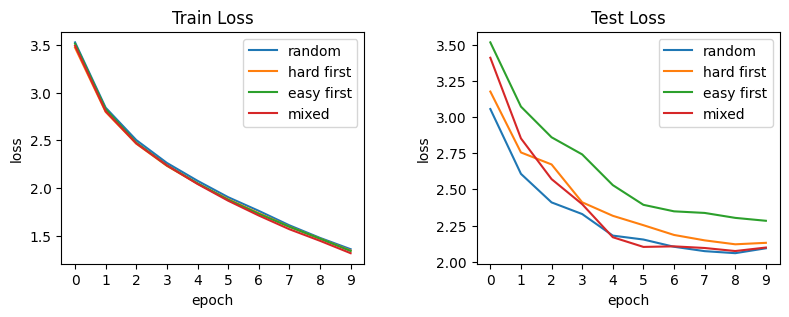

In [51]:
fig,axes = plt.subplots(1,2,figsize=(9, 4))
fig.tight_layout(pad=5.0)
for key,value in losses_train_history.items():
  axes[0].plot(range(n_epochs),tensor_list_to_list(value),label=str(key))
axes[0].set_title('Train Loss')
for key,value in losses_val_history.items():
  axes[1].plot(range(n_epochs),tensor_list_to_list(value),label=str(key))
axes[1].set_title('Test Loss')
for ax in axes:
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    
axes[0].set_xticks([i for i in range(n_epochs)]) 
axes[1].set_xticks([i for i in range(n_epochs)])
fig.show()